In [1]:
import gc
import os
import glob
import zipfile
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
import PIL
from PIL import ImageOps, ImageFilter, ImageDraw

In [2]:
!dir

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: CE66-DCE3

 C:\Users\AFFINITY 디렉터리

2019-11-05  오전 09:47    <DIR>          .
2019-11-05  오전 09:47    <DIR>          ..
2019-10-14  오후 03:21    <DIR>          .anaconda
2019-10-30  오전 09:50    <DIR>          .conda
2019-10-22  오전 10:53                43 .condarc
2019-10-30  오후 05:53    <DIR>          .designer
2019-10-14  오후 03:48               174 .gitconfig
2019-10-31  오전 09:46    <DIR>          .ipynb_checkpoints
2019-10-14  오후 04:48    <DIR>          .ipython
2019-10-16  오전 09:22    <DIR>          .jupyter
2019-10-16  오전 09:24    <DIR>          .keras
2019-10-14  오후 05:01    <DIR>          .matplotlib
2019-10-14  오후 05:49                91 .python_history
2019-10-07  오전 09:23    <DIR>          3D Objects
2019-10-30  오전 09:50    <DIR>          Anaconda3
2019-10-17  오후 02:01    <DIR>          ansel
2019-10-31  오전 11:16             5,881 application.ui
2019-10-31  오전 11:18             2,563 ApplicationRun.ipynb
2019-11-04  오후 02:17    <DIR>          b

2019-11-04  오후 12:35        38,958,632 위치-사람-위_mobile_model_0.90_0.3450.h5
2019-11-04  오전 11:14        38,958,632 위치-사람-위_mobile_model_0.93_0.2902.h5
2019-11-01  오후 03:41        38,958,632 위치-사람-정중앙_mobile_model_0.95_0.5574.h5
2019-11-01  오후 03:41        38,958,632 위치-사람-정중앙_mobile_model_0.95_0.5592.h5
2019-11-01  오후 03:41        38,958,632 위치-사람-정중앙_mobile_model_0.95_0.5621.h5
2019-11-01  오후 03:40        38,958,632 위치-사람-정중앙_mobile_model_0.95_0.5648.h5
2019-11-01  오후 03:40        38,958,632 위치-사람-정중앙_mobile_model_0.95_0.5666.h5
2019-11-01  오후 03:40        38,958,632 위치-사람-정중앙_mobile_model_0.95_0.5677.h5
2019-11-01  오후 03:40        38,958,632 위치-사람-정중앙_mobile_model_0.95_0.5712.h5
2019-11-01  오후 03:40        38,958,632 위치-사람-정중앙_mobile_model_0.95_0.5773.h5
2019-11-01  오후 03:39        38,958,632 위치-사람-정중앙_mobile_model_0.95_0.5822.h5
2019-11-01  오후 03:39        38,958,632 위치-사람-정중앙_mobile_model_0.95_0.5881.h5
2019-11-01  오후 03:39        38,958,632 위치-사람-정중앙_mobile_model_0.95_0.6447.h5
201

In [3]:
DATA_PATH = 'C:/Users/AFFINITY/data/splitlabel/'
IMAGE_PATH = 'C:/Users/AFFINITY/data/467case_cut-20190916T015832Z-001/'
os.listdir(DATA_PATH)

['sub_가지-부재.xlsx',
 'sub_가지-아래로 늘어진 가지.xlsx',
 'sub_가지-옆으로 벌어짐.xlsx',
 'sub_귀-부재.xlsx',
 'sub_기둥-상처, 옹이구멍.xlsx',
 'sub_기둥-옹이구멍 안 동물.xlsx',
 'sub_눈-점 혹은 단선의 눈.xlsx',
 'sub_다리-넓게 벌림.xlsx',
 'sub_다리-앉아있음.xlsx',
 'sub_머리-크다.xlsx',
 'sub_머리카락-윤곽선(검게 표현되지 않은 긴 머리).xlsx',
 'sub_문-격자무늬 창.xlsx',
 'sub_발-발가락 그림.xlsx',
 'sub_뿌리-부재2.xlsx',
 'sub_손-원모양 손, 주먹쥔 손.xlsx',
 'sub_수관-공 모양.xlsx',
 'sub_위치-나무-아래.xlsx',
 'sub_위치-나무-위.xlsx',
 'sub_위치-나무-정중앙.xlsx',
 'sub_위치-사람-아래.xlsx',
 'sub_위치-사람-오른쪽.xlsx',
 'sub_위치-사람-왼쪽.xlsx',
 'sub_위치-사람-위.xlsx',
 'sub_위치-사람-정중앙.xlsx',
 'sub_위치-집-아래.xlsx',
 'sub_위치-집-정중앙.xlsx',
 'sub_음영-사람-내부의 진한 음영.xlsx',
 'sub_입-웃음.xlsx',
 'sub_장식-타이, 벨트, 보석.xlsx',
 'sub_절단-나무-오른쪽.xlsx',
 'sub_절단-나무-위.xlsx',
 'sub_지면선-벽 밑면 있지만 지면 없음.xlsx',
 'sub_지붕-그물무늬 음영.xlsx',
 'sub_창문-격자무늬.xlsx',
 'sub_창문-많다.xlsx',
 'sub_창문-창문을 가린 커튼.xlsx',
 'sub_코-작다.xlsx',
 'sub_크기-나무-크다.xlsx',
 'sub_크기-사람-작다.xlsx',
 'sub_크기-사람-크다.xlsx',
 'sub_팔-길다.xlsx',
 'sub_팔-몸에 딱 붙음.xlsx',
 'test_가지-부재.xlsx',
 'test_가지-아래로 늘어

In [4]:
feature = [
        '문-격자무늬 창',
        '위치-집-아래',
        '위치-집-정중앙',
        '지면선-벽 밑면 있지만 지면 없음',
        '지붕-그물무늬 음영',
        '창문-격자무늬',
        '창문-많다',
        '창문-창문을 가린 커튼',
        "크기-사람-작다",
        "위치-사람-정중앙",
        "위치-사람-오른쪽",
        "음영-사람-내부의 진한 음영",
        "코-작다",
        "머리카락-윤곽선(검게 표현되지 않은 긴 머리)",
        "팔-길다",
        "손-원모양 손, 주먹쥔 손",
        "다리-넓게 벌림",
        "다리-앉아있음",
        "발-발가락 그림",
        "크기-사람-크다",
        "위치-사람-왼쪽",
        "위치-사람-위",
        "위치-사람-아래",
        "머리-크다",
        "눈-점 혹은 단선의 눈",
        "귀-부재",
        "입-웃음",
        "팔-몸에 딱 붙음",
        "장식-타이, 벨트, 보석"
]

In [5]:
IMG_PATH = os.path.join(IMAGE_PATH,'imagedata')

df_train = []
df_test = []
for excel_name in feature:
    df_train.append(pd.read_excel(os.path.join(DATA_PATH,'train_' + excel_name + '.xlsx')))
    df_train[feature.index(excel_name)]['data'] = df_train[feature.index(excel_name)].data.apply(lambda x: f'{x:0>4}')
    df_test.append(pd.read_excel(os.path.join(DATA_PATH,'test_' + excel_name + '.xlsx')))
    df_test[feature.index(excel_name)]['data'] = df_test[feature.index(excel_name)].data.apply(lambda x: f'{x:0>4}')

In [6]:
for i in range(len(feature)):
    print(df_train[i].head(5))
    print(df_test[i].head(5))

   Unnamed: 0        data  문-격자무늬 창
0         127  0237_H.jpg         0
1         169  0318_H.jpg         0
2          48  0080_H.jpg         0
3         216  0417_H.jpg         0
4         268  0495_H.jpg         0
   Unnamed: 0        data  문-격자무늬 창
0          60  0104_H.jpg         0
1         271  0498_H.jpg         0
2          22  0038_H.jpg         0
3         102  0196_H.jpg         0
4         109  0203_H.jpg         0
   Unnamed: 0        data  위치-집-아래
0           2  0004_H.jpg        0
1         186  0356_H.jpg        0
2         124  0234_H.jpg        0
3         103  0197_H.jpg        1
4          53  0091_H.jpg        0
   Unnamed: 0        data  위치-집-아래
0         233  0444_H.jpg        0
1          14  0023_H.jpg        0
2         152  0287_H.jpg        1
3          43  0073_H.jpg        1
4          28  0046_H.jpg        1
   Unnamed: 0        data  위치-집-정중앙
0         206  0397_H.jpg         0
1         153  0288_H.jpg         0
2         160  0301_H.jpg         0
3   

4         121  0216_P.jpg         0
   Unnamed: 0        data  발-발가락 그림
0         244  0461_P.jpg         0
1          84  0143_P.jpg         0
2          92  0163_P.jpg         0
3         128  0232_P.jpg         0
4          85  0144_P.jpg         0
   Unnamed: 0        data  크기-사람-크다
0         129  0233_P.jpg         0
1          55  0091_P.jpg         0
2         230  0443_P.jpg         0
3         153  0286_P.jpg         1
4         172  0332_P.jpg         0
   Unnamed: 0        data  크기-사람-크다
0         267  0500_P.jpg         0
1         287  0526_P.jpg         0
2         263  0494_P.jpg         1
3          94  0165_P.jpg         1
4          38  0067_P.jpg         0
   Unnamed: 0        data  위치-사람-왼쪽
0         192  0373_P.jpg         1
1         204  0403_P.jpg         0
2          51  0083_P.jpg         1
3         253  0476_P.jpg         1
4         169  0319_P.jpg         1
   Unnamed: 0        data  위치-사람-왼쪽
0          71  0115_P.jpg         1
1         172  0332_P.jpg   

C:\Users\AFFINITY\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


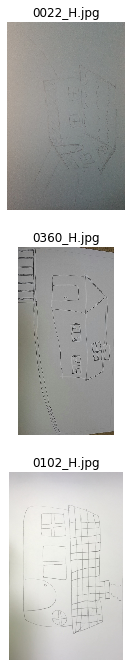

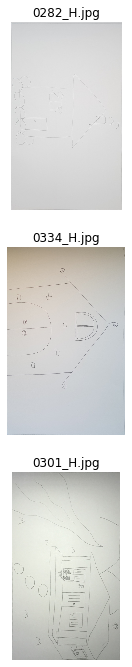

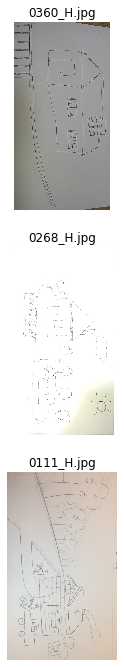

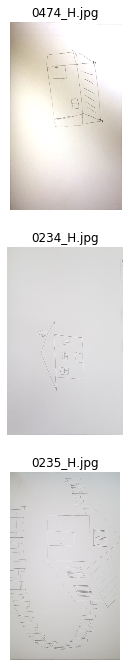

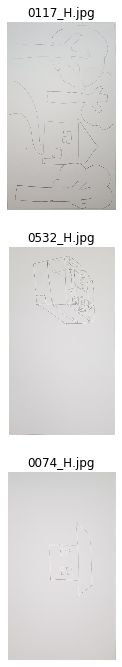

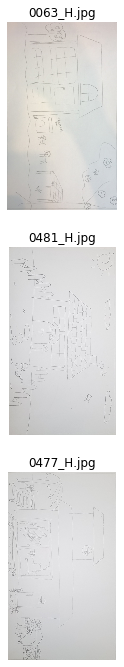

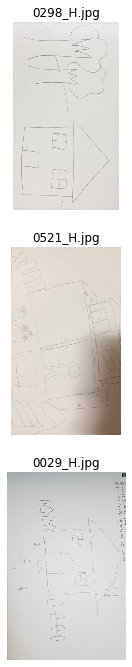

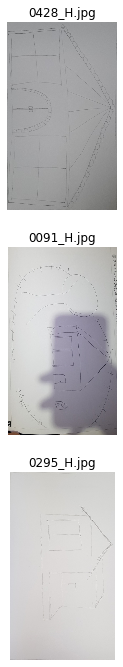

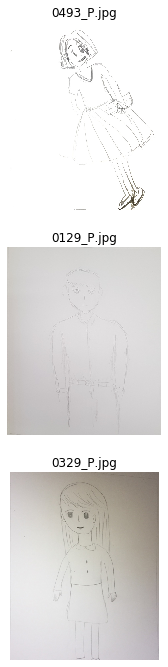

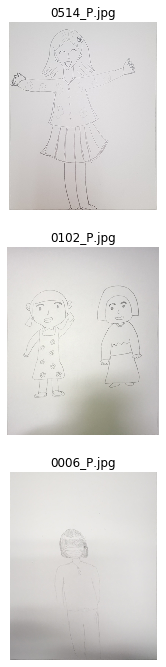

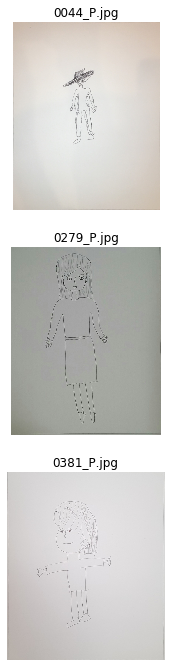

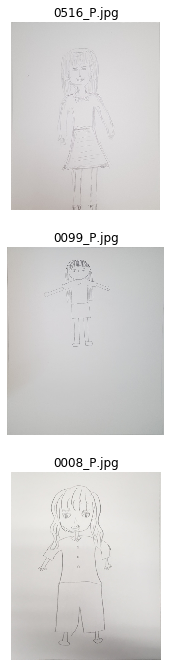

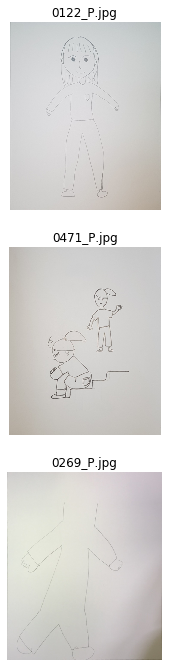

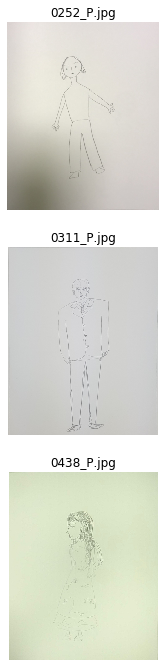

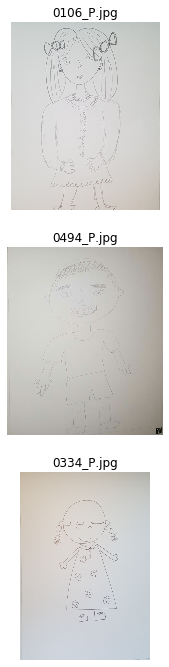

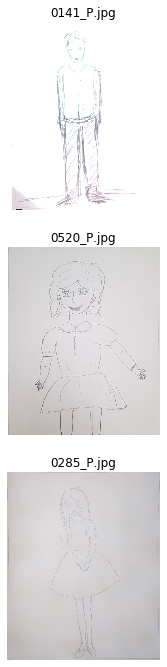

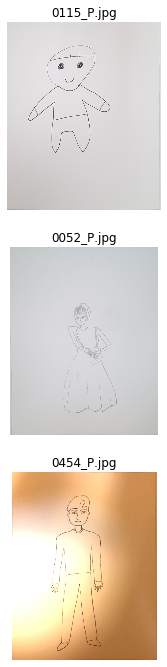

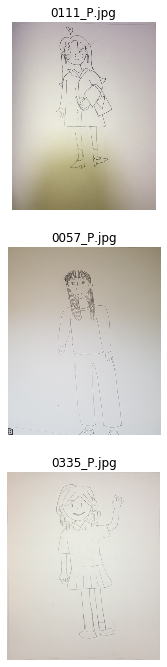

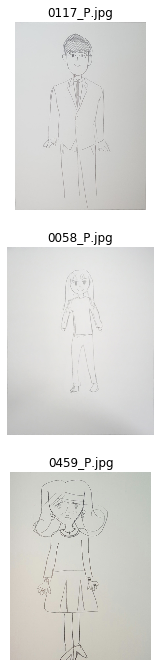

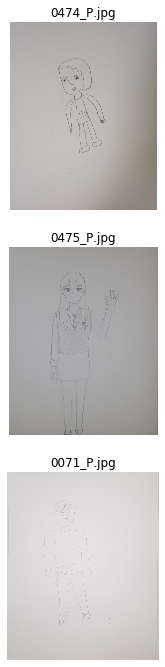

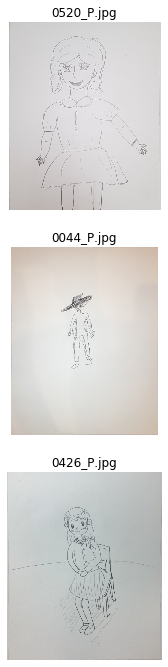

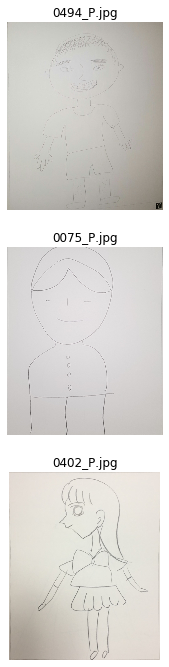

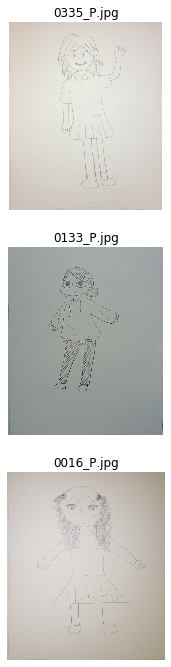

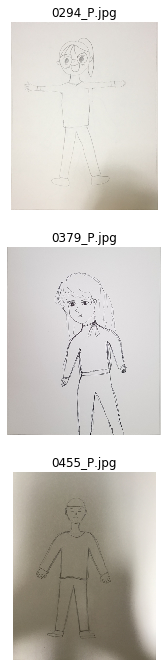

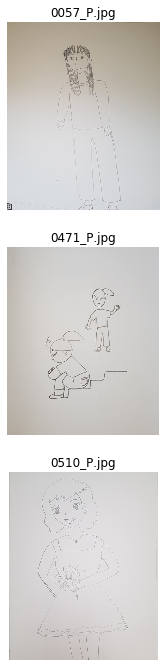

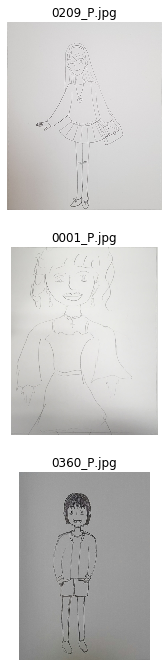

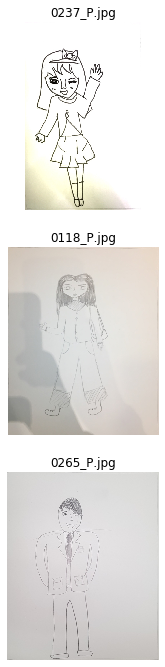

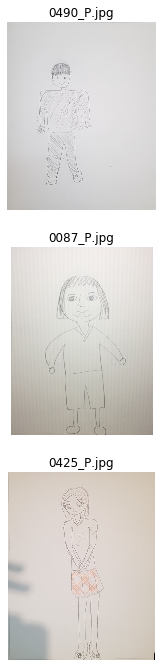

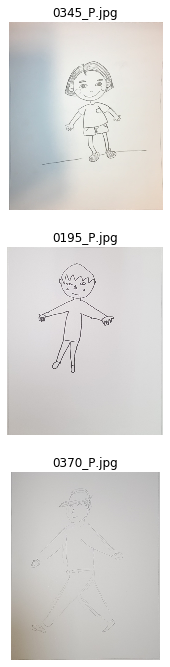

In [7]:
for i in range(len(df_train)):
    tmp_imgs = df_train[i]['data'][100:103]
    plt.figure(figsize=(12,20))
    for num, f_name in enumerate(tmp_imgs):
        img = PIL.Image.open(os.path.join(IMG_PATH, f_name))
        plt.subplot(5, 2, 2*num + 1)
        plt.title(f_name)
        plt.imshow(img)
        plt.axis('off')

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train = []
X_val = []

for i, data in enumerate(feature):
    df_train[i][data] = df_train[i][data].astype('str')
#     df_train[i][data] = to_categorical(df_train[i][data], 2)
    y = df_train[i][data]
    df_train[i] = df_train[i][['data', data]]
    df_test[i] = df_test[i][['data']]

    its = np.arange(df_train[i].shape[0])
    train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42, stratify=y)
    
    X_train.append(df_train[i].iloc[train_idx, :])
    X_val.append(df_train[i].iloc[val_idx, :])

    print(data)
    print(X_train[i].shape)
    print(X_val[i].shape)
    print(df_train[i].shape)
    print(df_test[i].shape)
    print("="*20)

문-격자무늬 창
(165, 2)
(42, 2)
(207, 2)
(90, 1)
위치-집-아래
(165, 2)
(42, 2)
(207, 2)
(90, 1)
위치-집-정중앙
(165, 2)
(42, 2)
(207, 2)
(90, 1)
지면선-벽 밑면 있지만 지면 없음
(165, 2)
(42, 2)
(207, 2)
(90, 1)
지붕-그물무늬 음영
(165, 2)
(42, 2)
(207, 2)
(90, 1)
창문-격자무늬
(165, 2)
(42, 2)
(207, 2)
(90, 1)
창문-많다
(165, 2)
(42, 2)
(207, 2)
(90, 1)
창문-창문을 가린 커튼
(165, 2)
(42, 2)
(207, 2)
(90, 1)
크기-사람-작다
(164, 2)
(41, 2)
(205, 2)
(89, 1)
위치-사람-정중앙
(164, 2)
(41, 2)
(205, 2)
(89, 1)
위치-사람-오른쪽
(164, 2)
(41, 2)
(205, 2)
(89, 1)
음영-사람-내부의 진한 음영
(164, 2)
(41, 2)
(205, 2)
(89, 1)
코-작다
(164, 2)
(41, 2)
(205, 2)
(89, 1)
머리카락-윤곽선(검게 표현되지 않은 긴 머리)
(164, 2)
(41, 2)
(205, 2)
(89, 1)
팔-길다
(164, 2)
(41, 2)
(205, 2)
(89, 1)
손-원모양 손, 주먹쥔 손
(164, 2)
(41, 2)
(205, 2)
(89, 1)
다리-넓게 벌림
(164, 2)
(41, 2)
(205, 2)
(89, 1)
다리-앉아있음
(164, 2)
(41, 2)
(205, 2)
(89, 1)
발-발가락 그림
(164, 2)
(41, 2)
(205, 2)
(89, 1)
크기-사람-크다
(164, 2)
(41, 2)
(205, 2)
(89, 1)
위치-사람-왼쪽
(164, 2)
(41, 2)
(205, 2)
(89, 1)
위치-사람-위
(164, 2)
(41, 2)
(205, 2)
(89, 1)
위치-사람-아래
(164, 2)
(41

In [9]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [10]:
epochs = 50
batch_size = 30
img_size = (224, 224)
# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = False, 
    vertical_flip = False,
    rotation_range = 3,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = []
validation_generator = []
test_generator = []

nb_train_samples = []
nb_validation_samples = []
nb_test_samples = []

for i, num in enumerate(feature):
    nb_train_samples.append(len(X_train[i]))
    nb_validation_samples.append(len(X_val[i]))
    nb_test_samples.append(len(df_test[i]))
    
    
    # Make Generator
    train_generator.append(train_datagen.flow_from_dataframe(
        dataframe=X_train[i], 
        directory=IMG_PATH,
        x_col = 'data',
        y_col = feature[i],
        target_size = img_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        seed=None
    ))

    validation_generator.append(val_datagen.flow_from_dataframe(
        dataframe=X_val[i], 
        directory=IMG_PATH,
        x_col='data',
        y_col=feature[i],
        target_size=img_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    ))

    test_generator.append(test_datagen.flow_from_dataframe(
        dataframe=df_test[i],
        directory=IMG_PATH,
        x_col='data',
        y_col=None,
        target_size=img_size,
        color_mode='rgb',
        class_mode=None,
        batch_size=batch_size,
        shuffle=False
    ))

Found 165 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 90 validated image filenames.
Found 165 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 90 validated image filenames.
Found 165 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 90 validated image filenames.
Found 165 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 90 validated image filenames.
Found 165 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 90 validated image filenames.
Found 165 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 90 validated image filenames.
Found 165 validated image filenames belonging to 2 classes.
Found 42 v

#이미지 생성 테스트 코드

img = load_img(IMAGE_PATH + 'imagedata/0001_H.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0

for batch in train_datagen.flow(x, batch_size=1, save_to_dir=IMAGE_PATH + 'house/preview', save_prefix='tri', save_format='png'):
    i += 1
    if i > 10: 
        break

In [11]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

In [12]:
def MakeMobileModel():
    mobileNetModel = MobileNet(
#         weights='imagenet',
        include_top=False)

    model = Sequential()
    model.add(mobileNetModel)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model
model = MakeMobileModel()
model.summary()

C:\Users\AFFINITY\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 3,209,026
Non-trainable params: 21,888
_________________________________________________________________


In [13]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else : 
        return num_samples // batch_size

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

history = []

for i in range(len(feature)):
    model = MakeMobileModel()
    filepath = feature[i] + "_mobile_model_{val_acc:.2f}_{val_loss:.4f}.h5"
    
    ckpt = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

    callbackList = [ckpt]

    history.append(model.fit_generator(
        train_generator[i],
        steps_per_epoch = get_steps(nb_train_samples[i], batch_size),
        epochs=epochs,
        validation_data = validation_generator[i],
        validation_steps = get_steps(nb_validation_samples[i], batch_size),
        callbacks = callbackList
    ))
    gc.collect()

Epoch 1/50
5/6 [========================>.....] - ETA: 16s - loss: 0.4071 - acc: 0.83 - ETA: 7s - loss: 0.4831 - acc: 0.8333 - ETA: 3s - loss: 0.3438 - acc: 0.866 - ETA: 2s - loss: 0.2896 - acc: 0.885 - ETA: 0s - loss: 0.3191 - acc: 0.8963
Epoch 00001: val_loss improved from inf to 0.26864, saving model to 문-격자무늬 창_mobile_model_0.98_0.2686.h5
6/6 [==============================] - 6s 954ms/step - loss: 0.2962 - acc: 0.9091 - val_loss: 0.2686 - val_acc: 0.9762
Epoch 2/50
5/6 [========================>.....] - ETA: 1s - loss: 0.0077 - acc: 1.000 - ETA: 1s - loss: 0.0567 - acc: 0.966 - ETA: 0s - loss: 0.0559 - acc: 0.973 - ETA: 0s - loss: 0.0743 - acc: 0.971 - ETA: 0s - loss: 0.0702 - acc: 0.9704
Epoch 00002: val_loss improved from 0.26864 to 0.26864, saving model to 문-격자무늬 창_mobile_model_0.98_0.2686.h5
6/6 [==============================] - 4s 666ms/step - loss: 0.0589 - acc: 0.9758 - val_loss: 0.2686 - val_acc: 0.9762
Epoch 3/50
5/6 [========================>.....] - ETA: 1s - loss: 0.0

Epoch 20/50
5/6 [========================>.....] - ETA: 1s - loss: 3.4651e-06 - acc: 1.000 - ETA: 2s - loss: 3.4194e-06 - acc: 1.000 - ETA: 2s - loss: 3.0637e-06 - acc: 1.000 - ETA: 1s - loss: 2.1542e-05 - acc: 1.000 - ETA: 0s - loss: 1.8445e-05 - acc: 1.0000
Epoch 00020: val_loss did not improve from 0.23687
6/6 [==============================] - 5s 822ms/step - loss: 1.8390e-05 - acc: 1.0000 - val_loss: 0.2686 - val_acc: 0.9762
Epoch 21/50
5/6 [========================>.....] - ETA: 1s - loss: 2.2571e-06 - acc: 1.000 - ETA: 1s - loss: 3.0141e-06 - acc: 1.000 - ETA: 1s - loss: 3.2445e-06 - acc: 1.000 - ETA: 1s - loss: 3.8073e-06 - acc: 1.000 - ETA: 0s - loss: 3.5112e-06 - acc: 1.0000
Epoch 00021: val_loss did not improve from 0.23687
6/6 [==============================] - 5s 796ms/step - loss: 4.8931e-06 - acc: 1.0000 - val_loss: 0.2686 - val_acc: 0.9762
Epoch 22/50
5/6 [========================>.....] - ETA: 1s - loss: 1.1727e-05 - acc: 1.000 - ETA: 1s - loss: 7.1399e-06 - acc: 1.000

Epoch 39/50
5/6 [========================>.....] - ETA: 1s - loss: 6.4672e-06 - acc: 1.000 - ETA: 2s - loss: 9.8823e-06 - acc: 1.000 - ETA: 1s - loss: 3.1821e-05 - acc: 1.000 - ETA: 1s - loss: 2.5019e-05 - acc: 1.000 - ETA: 0s - loss: 2.0113e-05 - acc: 1.0000
Epoch 00039: val_loss did not improve from 0.23687
6/6 [==============================] - 4s 694ms/step - loss: 1.7446e-05 - acc: 1.0000 - val_loss: 0.2687 - val_acc: 0.9762
Epoch 40/50
5/6 [========================>.....] - ETA: 0s - loss: 3.8747e-05 - acc: 1.000 - ETA: 1s - loss: 2.1240e-05 - acc: 1.000 - ETA: 1s - loss: 1.5807e-05 - acc: 1.000 - ETA: 0s - loss: 1.2552e-05 - acc: 1.000 - ETA: 0s - loss: 1.0411e-05 - acc: 1.0000
Epoch 00040: val_loss did not improve from 0.23687
6/6 [==============================] - 4s 655ms/step - loss: 8.8187e-06 - acc: 1.0000 - val_loss: 0.2687 - val_acc: 0.9762
Epoch 41/50
5/6 [========================>.....] - ETA: 1s - loss: 7.8604e-06 - acc: 1.000 - ETA: 1s - loss: 1.1451e-05 - acc: 1.000

6/6 [==============================] - 4s 667ms/step - loss: 0.0065 - acc: 1.0000 - val_loss: 1.7406 - val_acc: 0.5000
Epoch 8/50
5/6 [========================>.....] - ETA: 1s - loss: 0.0354 - acc: 0.966 - ETA: 1s - loss: 0.0179 - acc: 0.983 - ETA: 1s - loss: 0.0125 - acc: 0.988 - ETA: 0s - loss: 0.0400 - acc: 0.981 - ETA: 0s - loss: 0.0327 - acc: 0.9852
Epoch 00008: val_loss did not improve from 0.73651
6/6 [==============================] - 4s 677ms/step - loss: 0.0326 - acc: 0.9818 - val_loss: 1.4457 - val_acc: 0.5476
Epoch 9/50
5/6 [========================>.....] - ETA: 1s - loss: 0.0082 - acc: 1.000 - ETA: 1s - loss: 0.1582 - acc: 0.977 - ETA: 1s - loss: 0.1441 - acc: 0.973 - ETA: 0s - loss: 0.1081 - acc: 0.981 - ETA: 0s - loss: 0.0886 - acc: 0.9852
Epoch 00009: val_loss did not improve from 0.73651
6/6 [==============================] - 4s 696ms/step - loss: 0.0709 - acc: 0.9879 - val_loss: 1.7109 - val_acc: 0.5476
Epoch 10/50
5/6 [========================>.....] - ETA: 1s - lo

5/6 [========================>.....] - ETA: 1s - loss: 6.0416e-04 - acc: 1.000 - ETA: 1s - loss: 0.0072 - acc: 1.0000    - ETA: 1s - loss: 0.0049 - acc: 1.000 - ETA: 1s - loss: 0.0037 - acc: 1.000 - ETA: 0s - loss: 0.0030 - acc: 1.0000
Epoch 00027: val_loss did not improve from 0.73651
6/6 [==============================] - 4s 648ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.9141 - val_acc: 0.7857
Epoch 28/50
5/6 [========================>.....] - ETA: 1s - loss: 1.0561e-04 - acc: 1.000 - ETA: 1s - loss: 0.0120 - acc: 1.0000    - ETA: 1s - loss: 0.0080 - acc: 1.000 - ETA: 0s - loss: 0.0064 - acc: 1.000 - ETA: 0s - loss: 0.0053 - acc: 1.0000
Epoch 00028: val_loss did not improve from 0.73651
6/6 [==============================] - 4s 672ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 1.5130 - val_acc: 0.8095
Epoch 29/50
5/6 [========================>.....] - ETA: 1s - loss: 5.1978e-05 - acc: 1.000 - ETA: 1s - loss: 6.8656e-05 - acc: 1.000 - ETA: 1s - loss: 1.0014e-04 - acc: 1.000 -

5/6 [========================>.....] - ETA: 1s - loss: 5.2842e-04 - acc: 1.000 - ETA: 1s - loss: 3.0046e-04 - acc: 1.000 - ETA: 1s - loss: 2.4075e-04 - acc: 1.000 - ETA: 1s - loss: 1.8806e-04 - acc: 1.000 - ETA: 0s - loss: 1.5754e-04 - acc: 1.0000
Epoch 00046: val_loss did not improve from 0.73651
6/6 [==============================] - 4s 659ms/step - loss: 1.3461e-04 - acc: 1.0000 - val_loss: 1.5049 - val_acc: 0.8095
Epoch 47/50
5/6 [========================>.....] - ETA: 1s - loss: 5.4478e-05 - acc: 1.000 - ETA: 2s - loss: 6.8668e-05 - acc: 1.000 - ETA: 1s - loss: 5.5112e-05 - acc: 1.000 - ETA: 1s - loss: 8.8377e-05 - acc: 1.000 - ETA: 0s - loss: 1.8395e-04 - acc: 1.0000
Epoch 00047: val_loss did not improve from 0.73651
6/6 [==============================] - 4s 705ms/step - loss: 1.5930e-04 - acc: 1.0000 - val_loss: 1.5034 - val_acc: 0.8095
Epoch 48/50
5/6 [========================>.....] - ETA: 1s - loss: 2.0280e-04 - acc: 1.000 - ETA: 1s - loss: 1.6192e-04 - acc: 1.000 - ETA: 1s -

5/6 [========================>.....] - ETA: 1s - loss: 8.5415e-05 - acc: 1.000 - ETA: 1s - loss: 0.0011 - acc: 1.0000    - ETA: 1s - loss: 0.0413 - acc: 0.986 - ETA: 1s - loss: 0.0313 - acc: 0.990 - ETA: 0s - loss: 0.0290 - acc: 0.9926
Epoch 00015: val_loss did not improve from 0.30224
6/6 [==============================] - 4s 714ms/step - loss: 0.0246 - acc: 0.9939 - val_loss: 0.5373 - val_acc: 0.9524
Epoch 16/50
5/6 [========================>.....] - ETA: 1s - loss: 8.9351e-04 - acc: 1.000 - ETA: 1s - loss: 6.0436e-04 - acc: 1.000 - ETA: 1s - loss: 4.4086e-04 - acc: 1.000 - ETA: 1s - loss: 0.0135 - acc: 0.9917    - ETA: 0s - loss: 0.0109 - acc: 0.9926
Epoch 00016: val_loss did not improve from 0.30224
6/6 [==============================] - 4s 687ms/step - loss: 0.0094 - acc: 0.9939 - val_loss: 0.5373 - val_acc: 0.9524
Epoch 17/50
5/6 [========================>.....] - ETA: 1s - loss: 0.0015 - acc: 1.000 - ETA: 1s - loss: 0.0024 - acc: 1.000 - ETA: 1s - loss: 0.0017 - acc: 1.000 - ETA

5/6 [========================>.....] - ETA: 1s - loss: 2.7551e-05 - acc: 1.000 - ETA: 1s - loss: 1.5293e-05 - acc: 1.000 - ETA: 1s - loss: 2.6143e-05 - acc: 1.000 - ETA: 1s - loss: 2.3875e-05 - acc: 1.000 - ETA: 0s - loss: 1.5328e-04 - acc: 1.0000
Epoch 00034: val_loss did not improve from 0.30224
6/6 [==============================] - 4s 652ms/step - loss: 1.3062e-04 - acc: 1.0000 - val_loss: 0.5373 - val_acc: 0.9524
Epoch 35/50
5/6 [========================>.....] - ETA: 1s - loss: 1.1418e-04 - acc: 1.000 - ETA: 1s - loss: 5.7290e-05 - acc: 1.000 - ETA: 1s - loss: 3.9958e-05 - acc: 1.000 - ETA: 1s - loss: 3.4442e-05 - acc: 1.000 - ETA: 0s - loss: 3.3291e-05 - acc: 1.0000
Epoch 00035: val_loss did not improve from 0.30224
6/6 [==============================] - 4s 720ms/step - loss: 2.8154e-05 - acc: 1.0000 - val_loss: 0.5373 - val_acc: 0.9524
Epoch 36/50
5/6 [========================>.....] - ETA: 1s - loss: 1.4694e-04 - acc: 1.000 - ETA: 1s - loss: 1.0375e-04 - acc: 1.000 - ETA: 1s -

Epoch 3/50
5/6 [========================>.....] - ETA: 1s - loss: 0.3489 - acc: 0.800 - ETA: 1s - loss: 0.3348 - acc: 0.911 - ETA: 1s - loss: 0.2515 - acc: 0.933 - ETA: 0s - loss: 0.2085 - acc: 0.942 - ETA: 0s - loss: 0.2517 - acc: 0.9333
Epoch 00003: val_loss did not improve from 1.65376
6/6 [==============================] - 4s 663ms/step - loss: 0.3187 - acc: 0.9212 - val_loss: 5.7757 - val_acc: 0.6667
Epoch 4/50
5/6 [========================>.....] - ETA: 1s - loss: 0.0051 - acc: 1.000 - ETA: 1s - loss: 0.0112 - acc: 1.000 - ETA: 1s - loss: 0.1328 - acc: 0.966 - ETA: 1s - loss: 0.1522 - acc: 0.966 - ETA: 0s - loss: 0.1229 - acc: 0.9733
Epoch 00004: val_loss did not improve from 1.65376
6/6 [==============================] - 4s 664ms/step - loss: 0.1093 - acc: 0.9758 - val_loss: 5.7757 - val_acc: 0.6667
Epoch 5/50
5/6 [========================>.....] - ETA: 1s - loss: 0.0224 - acc: 1.000 - ETA: 1s - loss: 0.0407 - acc: 1.000 - ETA: 1s - loss: 0.0431 - acc: 0.986 - ETA: 0s - loss: 0.

Epoch 23/50
5/6 [========================>.....] - ETA: 1s - loss: 1.1074e-04 - acc: 1.000 - ETA: 1s - loss: 5.8696e-05 - acc: 1.000 - ETA: 1s - loss: 6.2606e-04 - acc: 1.000 - ETA: 0s - loss: 0.0305 - acc: 0.9810    - ETA: 0s - loss: 0.0246 - acc: 0.9852
Epoch 00023: val_loss did not improve from 1.65376
6/6 [==============================] - 4s 657ms/step - loss: 0.0208 - acc: 0.9879 - val_loss: 4.7110 - val_acc: 0.6905
Epoch 24/50
5/6 [========================>.....] - ETA: 1s - loss: 1.2291e-04 - acc: 1.000 - ETA: 2s - loss: 8.8201e-05 - acc: 1.000 - ETA: 1s - loss: 2.6716e-04 - acc: 1.000 - ETA: 1s - loss: 2.8594e-04 - acc: 1.000 - ETA: 0s - loss: 2.3253e-04 - acc: 1.0000
Epoch 00024: val_loss did not improve from 1.65376
6/6 [==============================] - 4s 720ms/step - loss: 5.2594e-04 - acc: 1.0000 - val_loss: 4.5021 - val_acc: 0.7143
Epoch 25/50
5/6 [========================>.....] - ETA: 1s - loss: 2.1933e-04 - acc: 1.000 - ETA: 1s - loss: 8.3901e-04 - acc: 1.000 - ETA: 

5/6 [========================>.....] - ETA: 1s - loss: 3.7949e-06 - acc: 1.000 - ETA: 1s - loss: 5.6993e-05 - acc: 1.000 - ETA: 1s - loss: 4.1222e-05 - acc: 1.000 - ETA: 0s - loss: 3.6387e-05 - acc: 1.000 - ETA: 0s - loss: 4.1013e-05 - acc: 1.0000
Epoch 00042: val_loss did not improve from 1.65376
6/6 [==============================] - 4s 673ms/step - loss: 8.8027e-05 - acc: 1.0000 - val_loss: 2.8987 - val_acc: 0.7619
Epoch 43/50
5/6 [========================>.....] - ETA: 1s - loss: 7.5282e-06 - acc: 1.000 - ETA: 1s - loss: 5.3139e-05 - acc: 1.000 - ETA: 1s - loss: 5.6355e-05 - acc: 1.000 - ETA: 0s - loss: 5.1879e-05 - acc: 1.000 - ETA: 0s - loss: 1.7375e-04 - acc: 1.0000
Epoch 00043: val_loss did not improve from 1.65376
6/6 [==============================] - 4s 693ms/step - loss: 1.5155e-04 - acc: 1.0000 - val_loss: 2.8250 - val_acc: 0.7619
Epoch 44/50
5/6 [========================>.....] - ETA: 1s - loss: 2.3189e-05 - acc: 1.000 - ETA: 1s - loss: 2.0706e-05 - acc: 1.000 - ETA: 1s -

Epoch 11/50
5/6 [========================>.....] - ETA: 1s - loss: 0.0048 - acc: 1.000 - ETA: 1s - loss: 0.0066 - acc: 1.000 - ETA: 1s - loss: 0.0476 - acc: 0.986 - ETA: 1s - loss: 0.0485 - acc: 0.981 - ETA: 0s - loss: 0.1196 - acc: 0.9704
Epoch 00011: val_loss improved from 0.53707 to 0.49930, saving model to 지붕-그물무늬 음영_mobile_model_0.81_0.4993.h5
6/6 [==============================] - 4s 732ms/step - loss: 0.1251 - acc: 0.9697 - val_loss: 0.4993 - val_acc: 0.8095
Epoch 12/50
5/6 [========================>.....] - ETA: 1s - loss: 0.1138 - acc: 0.966 - ETA: 1s - loss: 0.0621 - acc: 0.983 - ETA: 1s - loss: 0.0451 - acc: 0.988 - ETA: 0s - loss: 0.0520 - acc: 0.990 - ETA: 0s - loss: 0.1417 - acc: 0.9556
Epoch 00012: val_loss did not improve from 0.49930
6/6 [==============================] - 4s 678ms/step - loss: 0.1360 - acc: 0.9515 - val_loss: 2.0123 - val_acc: 0.7857
Epoch 13/50
5/6 [========================>.....] - ETA: 1s - loss: 0.0773 - acc: 1.000 - ETA: 1s - loss: 0.0480 - acc: 1

Epoch 00030: val_loss did not improve from 0.49930
6/6 [==============================] - 4s 702ms/step - loss: 0.0055 - acc: 0.9939 - val_loss: 1.8333 - val_acc: 0.7143
Epoch 31/50
5/6 [========================>.....] - ETA: 1s - loss: 0.0014 - acc: 1.000 - ETA: 2s - loss: 7.2014e-04 - acc: 1.000 - ETA: 1s - loss: 8.0290e-04 - acc: 1.000 - ETA: 1s - loss: 6.7098e-04 - acc: 1.000 - ETA: 0s - loss: 5.5886e-04 - acc: 1.0000
Epoch 00031: val_loss did not improve from 0.49930
6/6 [==============================] - 4s 744ms/step - loss: 7.3610e-04 - acc: 1.0000 - val_loss: 1.9150 - val_acc: 0.7381
Epoch 32/50
5/6 [========================>.....] - ETA: 1s - loss: 5.0173e-04 - acc: 1.000 - ETA: 1s - loss: 4.4991e-04 - acc: 1.000 - ETA: 1s - loss: 0.0300 - acc: 0.9867    - ETA: 0s - loss: 0.0226 - acc: 0.990 - ETA: 0s - loss: 0.0185 - acc: 0.9926

In [ ]:
for i in range(len(history)):
    print(feature[i])
    plt.plot(history[i].history['acc'])
    plt.plot(history[i].history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [ ]:
# Plot training & validation loss values
for i  in range(len(feature)):
    print(feature[i])
    plt.plot(history[i].history['loss'])
    plt.plot(history[i].history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [ ]:
model_list = []
for num, h in enumerate(feature):
    model_list.append(sorted([i for i in os.listdir() if h in i]))
    print(model_list[num])

In [ ]:
prediction = []
for i, h in enumerate(feature):
    model = MakeMobileModel()
    model.load_weights(model_list[i][-1])
    test_generator[i].reset()
    print()
    prediction.append(model.predict_generator(
        generator = test_generator[i],
        steps = get_steps(nb_test_samples[i], batch_size),
        verbose=1
        ))

In [ ]:
for i, h in enumerate(feature):
    predicted_class_indices=np.argmax(prediction[i], axis=1)
    print(len(predicted_class_indices))
    print('df_test', df_test[i].shape)
    print('prediction' , prediction[i].shape)
    print('='*10)
    # Generator class dictionary mapping
    labels = (train_generator[i].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    submission = pd.read_excel(os.path.join(DATA_PATH,'sub_' + h + '.xlsx'))
    submission[h + "_class"] = predictions
    print(submission.head(10))
    submission.to_excel("h_" + h + "_submission.xlsx", index=False)
    print('='*20)

## Confusion Matrix & f1_score 함수 정의

In [ ]:
from sklearn.metrics import f1_score,confusion_matrix

def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    font = {'family': 'NanumGothic', 'color':  'blue', 'weight': 'light', 'size': 12}

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax

In [ ]:
# def micro_f1(y_true, y_pred):
#     return f1_score(y_true, y_pred, average='micro')

for h in feature:
    try:
        submission = pd.read_excel("h_"+h+"_submission.xlsx")
        print(h , " : " , micro_f1(submission[h],submission[h+ '_class']))
        plot_confusion_matrix(submission[h],submission[h+'_class'], classes=[0,1], title='Confusion matrix')
    #     plot_confusion_matrix(submission[h],submission[h+'_class'], classes=[0,1], normalize=True, title='Normalize Confusion matrix')
    except Exception:
        print(e)
    
    

In [ ]:
# h = feature
def ConfusionMatrix(excel, h):
    TP, FN, FP, TN = 0, 0, 0, 0
    actual = excel[h]
    predicted = excel[h +'_class']
   
    for i in range(len(excel)):
        #print(type(actual[i]), type(predicted[i]))
        #print(actual[i], predicted[i])
        if(actual[i] == predicted[i]):
            if(actual[i] == 1):
                TP = TP + 1
            else:
                TN = TN + 1
        else:
            if(actual[i] == 1):
                FN = FN + 1
            else:
                FP = FP + 1
    FN = len(actual) - TP
    TN = len(predicted) - FP
    
    precision = TP / (TP + FP)
    neg_pred = TN / (TN + FN)
    sensi = TP / (TP + FN)
    spec = TN / (TN + FP)
    Accu = (TP+TN) / (TP+TN+FP+FN)
    
    return TP,FP,FN,TN,precision,neg_pred, sensi, spec, Accu     

In [ ]:
bestfeature = ['위치-집-아래',
              '지면선-벽 밑면 있지만 지면 없음',
              '지붕-그물무늬 음영']

In [11]:
for h in bestfeature:
    excel = pd.read_excel("./bestfeature/h_"+h+"_submission.xlsx")
    TP, FP, FN, TN, precision, neg_pred, sensi, spec, Accu = ConfusionMatrix(excel, h)
    print(h, '- confusion Matrix')
    print('='*20)
    print('actual : ', len(excel[h]))
    print('predictive : ', len(excel[h + '_class']))
    print('True Positive(TP) : ', TP)
    print('False Positive(FP) : ', FP)
    print('False Negative(FN) : ', FN)
    print('True Negative(TN) : ', TN)
    print('precision : ', precision)
    print('negatuve_predictive_value : ', neg_pred)
    print('sensitivity : ', sensi)
    print('specificity : ', spec)
    print('Accuracy : ', Accu)
    print("f1 score : " , micro_f1(excel[h],excel[h+ '_class']))
    print('='*40)

위치-집-아래 - confusion Matrix
actual :  90
predictive :  90
True Positive(TP) :  15
False Positive(FP) :  16
False Negative(FN) :  75
True Negative(TN) :  74
precision :  0.4838709677419355
negatuve_predictive_value :  0.4966442953020134
sensitivity :  0.16666666666666666
specificity :  0.8222222222222222
Accuracy :  0.49444444444444446
f1 score :  0.7333333333333333
지면선-벽 밑면 있지만 지면 없음 - confusion Matrix
actual :  90
predictive :  90
True Positive(TP) :  49
False Positive(FP) :  18
False Negative(FN) :  41
True Negative(TN) :  72
precision :  0.7313432835820896
negatuve_predictive_value :  0.6371681415929203
sensitivity :  0.5444444444444444
specificity :  0.8
Accuracy :  0.6722222222222223
f1 score :  0.6888888888888889
지붕-그물무늬 음영 - confusion Matrix
actual :  90
predictive :  90
True Positive(TP) :  17
False Positive(FP) :  6
False Negative(FN) :  73
True Negative(TN) :  84
precision :  0.7391304347826086
negatuve_predictive_value :  0.535031847133758
sensitivity :  0.18888888888888888
s